# Petri Net Parser and Simulation
This notebook demonstrates how to parse a Colored Petri Net (CPN) model, create a corresponding Petri net, and simulate the transition firing.


In [6]:
from snakes.nets import PetriNet, Place, MultiSet, Transition, Expression, Variable, Tuple
from snakes.plugins import load
import re
import sys
import os

load('gv', 'snakes.nets', 'nets')
from nets import PetriNet, Place, Transition, Variable, Expression

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

from main_code_function.functions_for_parsing import collect_all_data, load_cpn_file, get_page_block, get_globbox_block
from main_code_function.snakes_engine_main import create_snakes_net, create_colset_functions


Načítáme soubor modelu model_AB.cpn a extrahujeme informace o stránkách a globálních proměnných. Poté parsujeme všechna data.
Zobrazujeme všechna parsovaná data pro ověření správnosti načtení a parsování.

In [9]:
import pprint

file_path = 'model_AB.cpn'
root = load_cpn_file(file_path)
page_block = get_page_block(root)
globbox_block = get_globbox_block(root)
data = collect_all_data(page_block, globbox_block)

print("Data successfully loaded.")


print("\n=== Parsed Data ===")
pprint.pprint(data)



Data successfully loaded.

=== Parsed Data ===
{'arcs': [{'arc_id': 'ID1412338984',
           'expression': '1`in1',
           'order': '1',
           'orientation': 'PtoT',
           'placeend': 'ID1412338810',
           'transend': 'ID1412338861'},
          {'arc_id': 'ID1412339019',
           'expression': '1`in2',
           'order': '1',
           'orientation': 'PtoT',
           'placeend': 'ID1412338824',
           'transend': 'ID1412338861'},
          {'arc_id': 'ID1412339057',
           'expression': '1`(in1,in2)',
           'order': '1',
           'orientation': 'TtoP',
           'placeend': 'ID1412338841',
           'transend': 'ID1412338861'}],
 'colsets': [{'id': 'ID85042',
              'index_values': None,
              'layout': 'colset UNIT = unit;',
              'name': 'UNIT',
              'subtype': 'unit',
              'subtype_contents': None},
             {'id': 'ID4',
              'index_values': None,
              'layout': None,
        

Vytváříme a zobrazujeme informace o barvách (Color Sets) použité v Petriho síti.

In [10]:
colset_functions = create_colset_functions(data["colsets"])

print("\n=== Color Sets (Colsets) ===")
for colset in data["colsets"]:
    print(f"Colset Name: {colset['name']}")
    print(f"Type: {colset['subtype']}")
    if colset["subtype"] == "enum" and colset["subtype_contents"]:
        print(f"Values: {colset['subtype_contents']}")
    elif colset["subtype"] == "product" and colset["subtype_contents"]:
        print(f"Product Types: {colset['subtype_contents']}")
    print("-" * 40)



=== Color Sets (Colsets) ===
Colset Name: UNIT
Type: unit
----------------------------------------
Colset Name: BOOL
Type: bool
----------------------------------------
Colset Name: INT
Type: int
----------------------------------------
Colset Name: INTINF
Type: intinf
----------------------------------------
Colset Name: TIME
Type: time
----------------------------------------
Colset Name: REAL
Type: real
----------------------------------------
Colset Name: STRING
Type: string
----------------------------------------
Colset Name: IN
Type: enum
Values: ['A', 'B']
----------------------------------------
Colset Name: OUT
Type: product
Product Types: ['IN', 'IN']
----------------------------------------


Na základě parsovaných dat vytváříme Petriho síť a zobrazujeme informace o místech (places) a jejich počátečních tokenech.
Generujeme obrázek aktuální Petriho sítě a zobrazujeme jej přímo v notebooku.

=== Places and Tokens ===
Place: P1, Tokens: ['A', 'B'], CheckType: IN
Place: P2, Tokens: ['B', 'B'], CheckType: IN
Place: P3, Tokens: [], CheckType: OUT


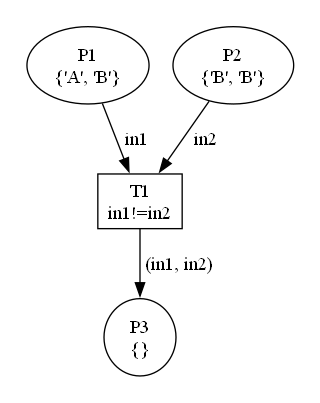

In [11]:
net, places_info, variables = create_snakes_net(data, colset_functions)

print("=== Places and Tokens ===")
for place_name, tokens, place_type in places_info:
    print(f"Place: {place_name}, Tokens: {list(tokens)}, CheckType: {place_type}")

net.draw("ex1.png", engine="dot")
from IPython.display import Image
Image("ex1.png")


Vypisujeme všechny přechody (transitions) a jejich vstupní a výstupní oblouky (arcs).

In [12]:
print("=== Transitions and Arcs ===")
for transition in net.transition():
    print(f"Transition: {transition.name}, Guard: {transition.guard}")
    for place, arc_label in transition.input():
        print(f"  Input Arc: {place.name} -> {transition.name}, Label: {arc_label}")
    for place, arc_label in transition.output():
        print(f"  Output Arc: {transition.name} -> {place.name}, Label: {arc_label}")


=== Transitions and Arcs ===
Transition: T1, Guard: in1!=in2
  Input Arc: P1 -> T1, Label: in1
  Input Arc: P2 -> T1, Label: in2
  Output Arc: T1 -> P3, Label: (in1, in2)


Zkoušíme spustit přechod T1, pokud je dostupný binding. Vypisujeme informace o bindingu a výsledku.

In [13]:
transition_name = "T1"
print(f"Attempting to fire Transition: {transition_name}")

try:
    transition = net.transition(transition_name)
    modes = transition.modes()
    if modes:
        print(f"Possible bindings found: {modes}")
        for binding in modes:
            print(f"Firing with binding: {binding}")
            transition.fire(binding)
            print(f"Transition '{transition_name}' fired successfully with binding: {binding}")
            break
    else:
        print(f"No available bindings for Transition '{transition_name}'")
except Exception as e:
    print(f"Error firing Transition '{transition_name}': {e}")


Attempting to fire Transition: T1
Possible bindings found: [Substitution(in1='A', in2='B'), Substitution(in1='A', in2='B')]
Firing with binding: {in1 -> 'A', in2 -> 'B'}
Transition 'T1' fired successfully with binding: {in1 -> 'A', in2 -> 'B'}


Zobrazujeme nový stav Petriho sítě po úspěšném spuštění přechodu a generujeme nový obrázek.


Places and their tokens after fire:
Place: P1, Tokens: ['B']
Place: P2, Tokens: ['B']
Place: P3, Tokens: [('A', 'B')]


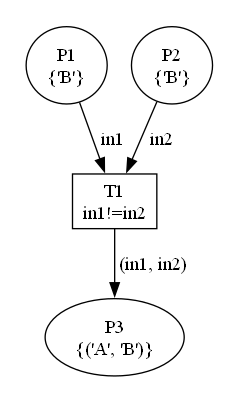

In [14]:
print("\nPlaces and their tokens after fire:")
for place in net.place():
    print(f"Place: {place.name}, Tokens: {list(place.tokens)}")

net.draw("ex2.png", engine="dot")
Image("ex2.png")
